In [2]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)

n_points = 600
time = np.arange(n_points)


X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)


for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.8 * X1[t-1])
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.7 * X2[t-1] )



X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.2 for i in range(len(X3)) if X3[i] > 0]

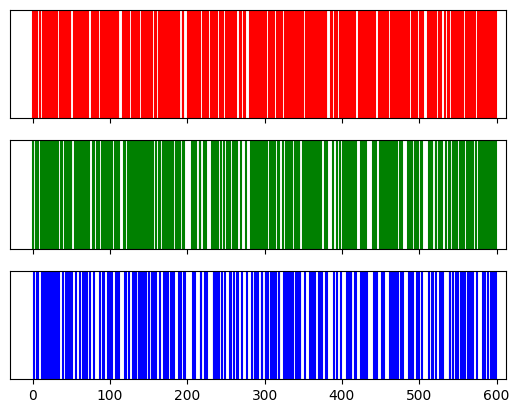

In [3]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [269]:
sigma = torch.rand(size = (10, 20))
mean = torch.rand(size = (10, 20))

kl = -1*(1 + sigma - torch.pow(mean, 2) - torch.exp(sigma))
kl.shape

torch.Size([10, 20])

In [290]:
import torch

class ProbRNN(nn.Module):
    def __init__(self, memory_size, gmm_size : int = 4):
        super().__init__()

        self.gmm_size = 20
        self.memory_size = memory_size
        self.linear = nn.Sequential(nn.Linear(self.memory_size, 32), nn.LayerNorm(32), nn.LeakyReLU(), nn.Linear(32, 64), nn.LayerNorm(64), nn.LeakyReLU())
        self.lstm = nn.GRU(input_size = 64, hidden_size = 128, num_layers = 2, batch_first = True)
        self.lstm_norm = nn.LayerNorm(128)
        self.linear_mu = nn.Sequential(nn.Linear(128, self.gmm_size), nn.LayerNorm(self.gmm_size))
        self.linear_std = nn.Sequential(nn.Linear(128, self.gmm_size), nn.LayerNorm(self.gmm_size))
        self.linear_gmm_weights = nn.Sequential(nn.Linear(128, self.gmm_size), nn.LayerNorm(self.gmm_size), nn.Softmax(dim = 1))


    def forward(self, x):
      debug_x = x.clone()
      x = self.linear(x)
      x, _ = self.lstm(x)
      x = self.lstm_norm(x)
      mu = self.linear_mu(x)
      std = self.linear_std(x)
      #std = torch.exp(std)
      kl = self.kl_loss(mu, std)


      return None, kl

    def kl_loss(self, mean, sigma):

        kl = (1 + sigma - torch.pow(mean, 2) - torch.exp(sigma))
        #kl = torch.sum(kl, axis = -1)

        return kl


    # def build_distrib(self, mus, stds, gmm_weights):



    #   component_dist = torch.distributions.Normal(mus.T, stds.T)
    #   mix_weight = torch.distributions.Categorical(gmm_weights.T)
    #   mix_dist = torch.distributions.MixtureSameFamily(mix_weight, component_dist)

    #   self.mix_dist = mix_dist


    #   return mix_dist

    # def sample(self, mu, std):
    #   size = (std.size(0),)

    #   X =  mu + self.mix_dist.sample(size)*std

    #   return X


In [291]:
rede = ProbRNN(memory_size = 4)
sum(p.numel() for p in rede.parameters())

184148

In [282]:
# rede(torch.rand(size = (10,4)))

In [264]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

In [265]:
# torch.linspace(2, 0.5, 200)

In [302]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):

        super().__init__()

        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)



        self.GrangerMatrix = nn.Parameter((torch.empty(self.n_processes, self.n_processes)))
        nn.init.normal_(self.GrangerMatrix, mean=0.5, std=0.1) # very important


        self.models = nn.ModuleList([ProbRNN(self.memory_dim) for i in range(self.n_processes)])
        self.sweep_dict = self.make_sweep_dict()
        self.time_of_start = self.get_time_of_start()
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()) + [self.GrangerMatrix], lr=1e-4, weight_decay = 1e-5) for i in range(self.n_processes)]
        #self.g_optimizer = torch.optim.Adam([self.GrangerMatrix], lr=1e-2, weight_decay = 1e-5)
        self.log_GrangerMatrix = []


    def em_step(self, n_steps):
        dic = {}
        self.causes = [[], [], []]
        for i in range(self.n_processes):
            dic[i] = []


        taus = torch.linspace(1, 0.3, steps = n_steps)
        for self.step in range(n_steps):
          for i_proc in range(self.n_processes):
              self.causes[i_proc] = []
              curr = processes[i_proc]
              len_curr = len(curr)
              idx_start = 0
              while idx_start < len_curr:
                self.num_events = 1
                events = self.get_events(self.num_events, idx_start, i_proc, taus[self.step]) ## the get_events does the e_step!
                if events:
                  DL = DataLoader(events, batch_size = len(events))

                  for X, cause_rank in DL:

                    loss = self.m_step(i_proc, X, cause_rank)
                    dic[i_proc].append(loss)

                idx_start += self.num_events

              if (self.step + 1) % 5 == 0 or self.step == 0:
                  print(f'Step: {self.step + 1}, Model: {i_proc}, Loss: {loss}')


        return dic

    def m_step(self, i_proc, X, cause_rank):

        model = self.models[i_proc]
        self.optimizers[i_proc].zero_grad()
        #self.g_optimizer.zero_grad()

        z, kl = model(X)
        loss = -1*kl.sum(axis = 1)

        loss_rnn = (loss * cause_rank).sum()  + -1*(torch.log(cause_rank + 1e-7)).sum()


        if not (torch.isnan(loss_rnn) | torch.isinf(loss_rnn)):


            loss_rnn.backward(retain_graph = True)

            self.optimizers[i_proc].step()
            #self.g_optimizer.step()
            self.log_GrangerMatrix.append(self.GrangerMatrix.clone().detach())


        else:
            print(f'NaN found in epoch: {self.step}')

        return loss_rnn.item()

    def make_sweep_dict(self):

        dic = {}
        for i in range(self.n_processes):
            target = processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)

        return dic


    def sweep(self, pa, pc):
        events = []
        pa_indices = []


        for i, ia in enumerate(pa):
            events.append((ia, 'a'))
            pa_indices.append(i)

        for ic in pc:
            events.append((ic, 'c'))

        lim = self.memory_dim

        events.sort()
        mem = []
        ret = []
        index_start = False

        pa_idx_counter = 0  # Counter to track which index in pa we are at

        for t, e in events:
            if e == 'c':
                if len(mem) >= lim:
                    mem.pop(0)
                mem.append(t)

            if e == 'a':
                # Memory is not full yet
                if len(mem) < lim:
                    pa_idx_counter += 1  # Move to the next pa index
                    continue
                # Retrieve deltas from this time to the cause times
                pp = [t - tc for tc in mem]
                ret.append(pp)
                if not index_start:
                  index_start = pa_indices[pa_idx_counter] # Save index relative to pa
                pa_idx_counter += 1  # Move to the next pa index
        if not index_start:
          index_start = -1
        return torch.tensor(ret, dtype=torch.float), index_start

    def get_time_of_start(self):

      indexs = []
      dic = self.sweep_dict

      for i in dic:
        curr = []
        for j in dic[i]:
          curr.append(dic[i][j][1])
        indexs.append(curr)

      return indexs


    def new_e_step(self, num_events, i_proc, tau):

      in_ = self.GrangerMatrix[i_proc].softmax(dim = 0)
      rv = []
      for i in range(num_events):
        cause = F.gumbel_softmax(
            in_,
            tau = tau,
            hard = False
        )
        rv.append(cause)

      self.causes[i_proc].append(rv)

      return rv


    def get_events(self, num_events, idx_start, i_proc, tau):

      begin_of_influences = self.time_of_start[i_proc]
      n_causes = self.new_e_step(num_events, i_proc, tau)

      event_cause = []

      for time in range(num_events):
        causes = n_causes[time]

        for idx_cause, cause in enumerate(causes):
          inf_begin = begin_of_influences[idx_cause]

          if inf_begin == -1: ## this process cannot be caused by this other process (it started after the current process ended)
            continue

          else:
            if time + idx_start >= inf_begin and len(self.sweep_dict[i_proc][idx_cause][0]) > time + idx_start: ## checking if the current_timestamp could be cause by the process and if there's events pass this time
              app = (self.sweep_dict[i_proc][idx_cause][0][time + idx_start], cause)
              event_cause.append(app)

      return event_cause



In [303]:
mpp = GrangerMPP(processes, memory_dim = 4)
l = mpp.em_step(n_steps = 200)

Step: 1, Model: 0, Loss: 4.231807708740234
Step: 1, Model: 1, Loss: 6.004756450653076
Step: 1, Model: 2, Loss: 11.457707405090332
Step: 5, Model: 0, Loss: 3.7078540325164795
Step: 5, Model: 1, Loss: 3.7204551696777344
Step: 5, Model: 2, Loss: 4.496950626373291
Step: 10, Model: 0, Loss: 4.624392032623291
Step: 10, Model: 1, Loss: 6.698791980743408
Step: 10, Model: 2, Loss: 4.5659565925598145
Step: 15, Model: 0, Loss: 2.9680676460266113
Step: 15, Model: 1, Loss: 2.893042802810669
Step: 15, Model: 2, Loss: 2.864800453186035
Step: 20, Model: 0, Loss: 3.1016883850097656
Step: 20, Model: 1, Loss: 2.88259220123291
Step: 20, Model: 2, Loss: 2.570967197418213
Step: 25, Model: 0, Loss: 2.074052572250366
Step: 25, Model: 1, Loss: 0.8323464393615723
Step: 25, Model: 2, Loss: 1.9637305736541748
Step: 30, Model: 0, Loss: 0.6355729103088379
Step: 30, Model: 1, Loss: 2.412900924682617
Step: 30, Model: 2, Loss: 1.9062308073043823
Step: 35, Model: 0, Loss: 0.20620068907737732
Step: 35, Model: 1, Loss: 2

In [301]:
mpp.GrangerMatrix.softmax(dim = 1)

tensor([[0.3094, 0.3475, 0.3431],
        [0.3445, 0.3366, 0.3189],
        [0.3408, 0.3348, 0.3243]], grad_fn=<SoftmaxBackward0>)

In [160]:
def get_time_of_start(dic = mpp.sweep_dict):

  indexs = []

  for i in dic:
    curr = []
    for j in dic[i]:
      curr.append(dic[i][j][1])
    indexs.append(curr)


  return indexs

matrix = torch.rand(size = (3,3))

def new_e_step(num_events, i_proc):

  in_ = matrix[i_proc]
  rv = []
  for i in range(num_events):
    cause = F.gumbel_softmax(
        in_,
        tau = 1,
        hard = False
    )
    rv.append(cause)

  return rv


def get_events(num_events, idx_start, i_proc, sweep_dict):

  begin_of_influences = get_time_of_start()[i_proc]
  n_causes = new_e_step(num_events, i_proc)

  event_cause = []

  for time in range(num_events):
    causes = n_causes[time]

    for idx_cause, cause in enumerate(causes):
      inf_begin = begin_of_influences[idx_cause]

      if inf_begin == -1: ## this process cannot be caused by this other process (it started after the current process ended)
        continue

      else:
        if time + idx_start >= inf_begin and len(sweep_dict[i_proc][idx_cause][0]) > time + idx_start: ## checking if the current_timestamp could be cause by the process and if there's events pass this time
          app = (sweep_dict[i_proc][idx_cause][0][time + idx_start], cause)
          event_cause.append(app)

  return event_cause







In [289]:
mpp.GrangerMatrix.softmax(dim=1)

tensor([[0.3332, 0.3333, 0.3335],
        [0.3333, 0.3336, 0.3331],
        [0.3334, 0.3332, 0.3334]], grad_fn=<SoftmaxBackward0>)

Len of losses: [13800, 11400, 8200]


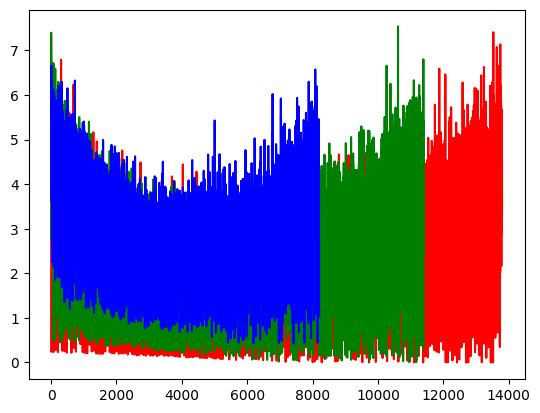

In [285]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

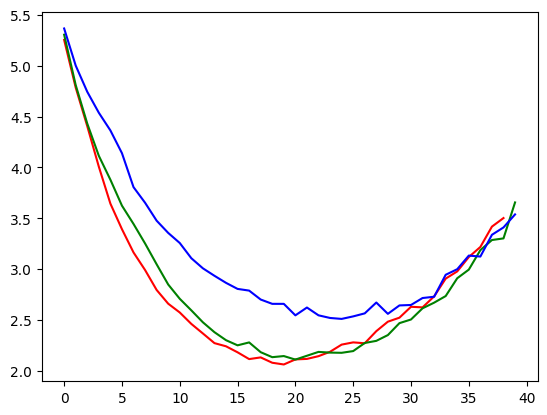

In [286]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

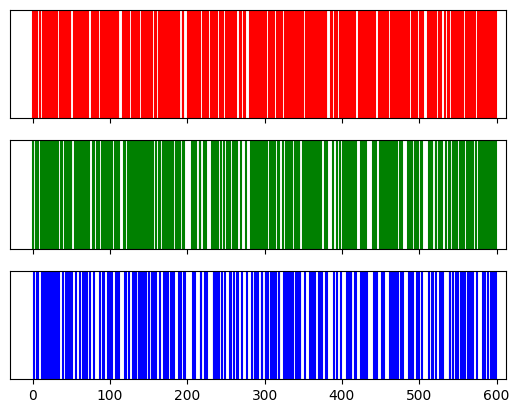

In [195]:
fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [197]:
# fig, ax = plt.subplots(nrows=2, sharex = True)
# colors = ['red', 'green', 'blue']
# idx = 0
# proc_to_plot = processes[idx].detach().cpu().numpy()
# _plot_tick_bars(proc_to_plot, ax[0], color = colors[idx])
# _plot_tick_bars_causes(proc_to_plot, ax[1], cause = mpp.causes[idx])


In [ ]:
# mpp.GrangerMatrix.detach().cpu().numpy()

In [199]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[1.0915278 , 1.0433694 , 1.0154053 ],
       [1.0573263 , 0.88946265, 1.003537  ],
       [0.87214   , 1.0637593 , 0.979908  ]], dtype=float32)

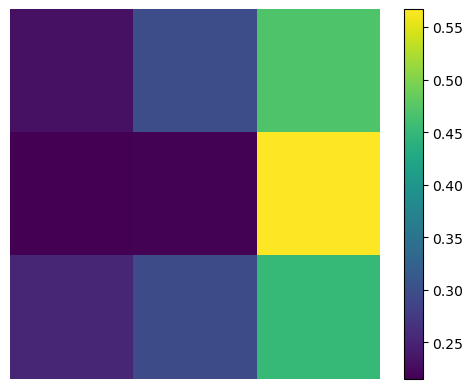

In [ ]:
X = mpp.GrangerMatrix.detach().cpu().numpy()
X = (X.T/X.sum(axis = 1)).T
plt.imshow(X)
plt.axis('off')
plt.colorbar()

In [ ]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[ 0.996765  , -0.00235457,  0.00471825],
       [ 0.33289954,  0.33716395,  0.3306691 ],
       [ 0.42307693,  0.01438018,  0.56958264]], dtype=float32)

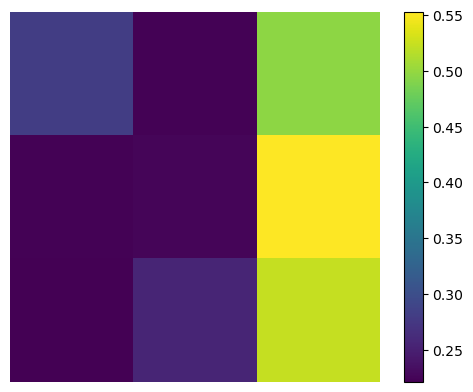

In [ ]:
s = mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

plt.imshow(s)
plt.axis('off')
plt.colorbar()